# Random Walk Example

Consider $y_i$ to be the % change in total personnel during last year for n companies problem.

We modelled it the following way:

$y_i | \mu \overset{\text{i.i.d.}}{\sim} N(\mu, 1) $ where $i = 1,...,n$

$\mu \sim t(0,1,1)$

Since this model is not conjugate, we cannot sample this easily, therefore we use MCMC method.

We also found the form of posterior distribution as follows:

$p(\mu | y_1,...,y_n) \propto \frac{exp[n(\bar y \mu - n\mu^2 / 2)]}{1 + \mu^2}$

The RHS is our $g(.)$

First we will make a function that evaluates the $g(.)$

Now, note that the $g(.)$ function deals with probabilities, thus it might be possible that it may output such a small number that may get rounded out to be zero by the computer. To tackle that, instead of calculating $g(.)$ directly, we calculate $log(g(.))$

$log(g(\mu)) = n(\bar y \mu - n\mu^2/2) - log(1+\mu^2)$

In [2]:
lg = function(mu, n, ybar){
    
    log_g = n * (ybar*mu - n*(mu^2)/2) - log(1 + mu^2)
    
    log_g
    
}

Writing a function for Random Walk Metropois - Hastings Sampler using Normal proposal distribution

In [29]:
MetroHast =function(n, ybar, m, mu_init, cand_sd){
    
    mu_out = numeric(m)
    
    #It is usually considered good to keep track of the number of times our candidates
    #are accepted
    
    n_cand_acc = 0
    
    mu_now = mu_init
    lg_now = lg(mu_now, n, ybar)
    
    
    
    for (i in 1:m){
        
        mu_cand = rnorm(1,mean = mu_now, sd = cand_sd) # Since this is Random Walk MH Sampler
        
        #Calculating the acceptance ratio
        #Note that in Random Walk, the proposal distribution is symmetric, thus the q values will cancel.
        
        lg_cand = lg(mu_cand, n, ybar)
        
        log_alpha = lg_cand - lg_now
        
        alpha = exp(x = log_alpha)
        
        
        #Calculating whether to accept or not
        
        #Writing longer code for explainability
        
        if (alpha >= 1){
            
            mu_now = mu_cand
            n_cand_acc = n_cand_acc + 1
            lg_now = lg_cand
            
        }
        
        
        else if (alpha < 1){
            
            prob = runif(1)
            
            if (alpha > prob){
                mu_now = mu_cand
                n_cand_acc = n_cand_acc + 1
                lg_now = lg_cand
            }
            
        }
        
        mu_out[i] = mu_now
        
    }
    
    list(mu = mu_out, n_accepts_rate = n_cand_acc / m)
    
}

Testing the function with n = 10 companies

In [8]:
y = c(1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9)

In [9]:
ybar = mean(y)

In [10]:
ybar

[1] 0.99

In [11]:
n = length(y)

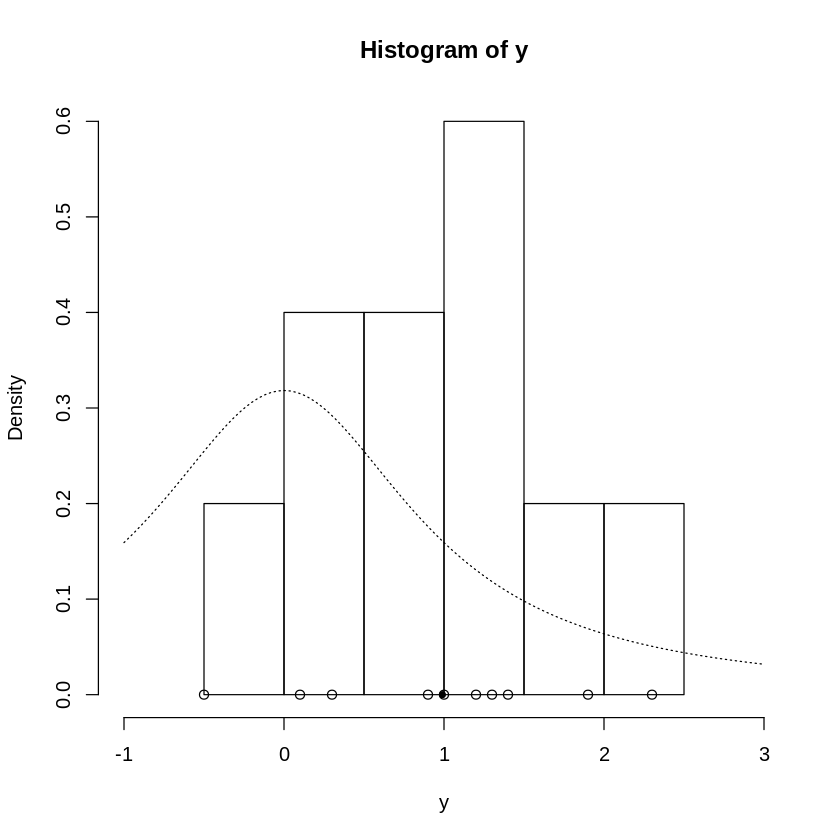

In [21]:
hist(y, freq = FALSE, xlim = c(-1,3))
points(y, rep(x = 0.0, n))
points(ybar, 0, pch = 20)


#prior distribution for the mean (mu)

curve(dt(x = x,df = 1), lty = 3, add =TRUE)

Prior distribution says that mean is around 0, but data suggests mean is around 1, thus we expect posterior beliefs to have mean somewhere between 0 and 1, compromising between both the values.

### Calculating Posterior Distribution

In [38]:
set.seed(43)
posterior_distrib = MetroHast(n, ybar, m = 1000, mu_init = 0, cand_sd = 3.0)

In [39]:
str(posterior_distrib)

List of 2
 $ mu            : num [1:1000] -0.113 -0.113 -0.113 -0.113 -0.113 ...
 $ n_accepts_rate: num 0.035


Since the acceptance rate is less than 23%, this shows that our step size might be a bit high.

We generally try to look for acceptance rate between 0.23 and 0.5 while working in Metropolis-Hastings

#### To explore the Posterior Distribution, we will use "coda" package.

In [32]:
library("coda")

ERROR: Error in library("coda"): there is no package called ‘coda’


In [33]:
install.packages("coda")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [40]:
library("coda")

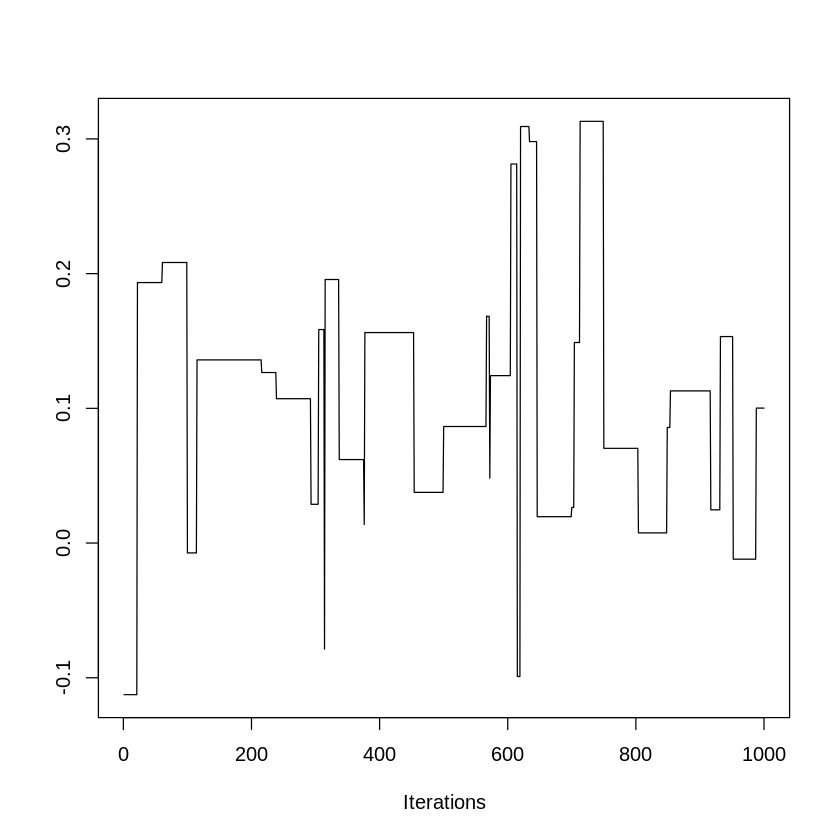

In [41]:
traceplot(as.mcmc(posterior_distrib$mu))

### If we want to increase the acceptance rate, we need to decrease the candidate standard deviation.

In [42]:
set.seed(43)
posterior_distrib = MetroHast(n, ybar, m = 1000, mu_init = 0, cand_sd = 0.05)

In [43]:
str(posterior_distrib)

List of 2
 $ mu            : num [1:1000] -0.00188 0.02512 0.03053 0.03137 0.08822 ...
 $ n_accepts_rate: num 0.853


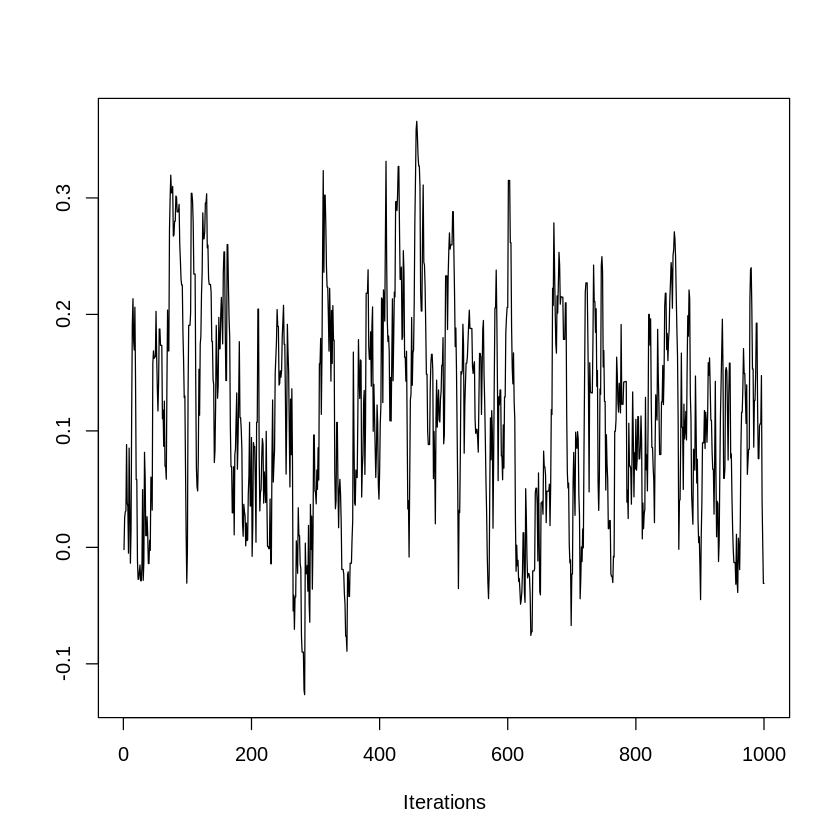

In [44]:
traceplot(as.mcmc(posterior_distrib$mu))

The step sizes are small, the chain wanders and it takes a long time to explore it all.

Also, the acceptance rate is too high (85.3%), so let's increase candidate standard deviation bya little bit.

In [59]:
posterior_distrib = MetroHast(n, ybar, m = 1000, mu_init = 0, cand_sd = 0.3)

In [60]:
str(posterior_distrib)

List of 2
 $ mu            : num [1:1000] 0.2473 0.014 0.014 0.1508 0.0114 ...
 $ n_accepts_rate: num 0.392


That's pretty good

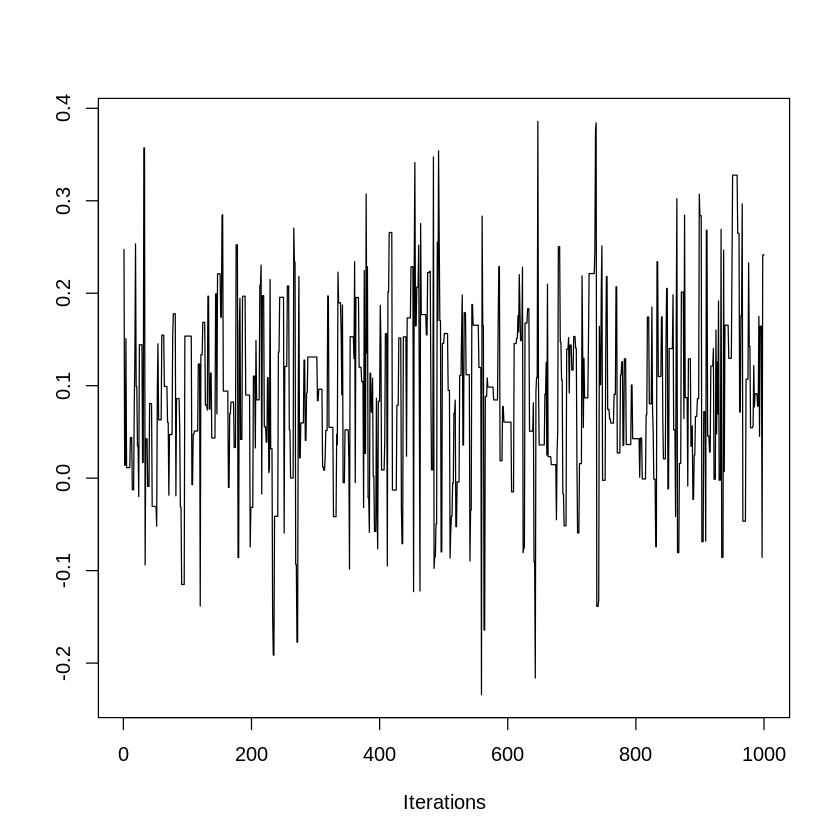

In [61]:
traceplot(as.mcmc(posterior_distrib$mu))

That looks like a perfect amount of exploration and still getting stuck at times.

### Now let's look at what happens when we change the initial parameter value ($\mu$ in this case) to some extreme value.

In [62]:
posterior_distrib = MetroHast(n, ybar, m = 1000, mu_init = 30.0, cand_sd = 0.3)

In [63]:
str(posterior_distrib)

List of 2
 $ mu            : num [1:1000] 30 30 30 30 29.6 ...
 $ n_accepts_rate: num 0.405


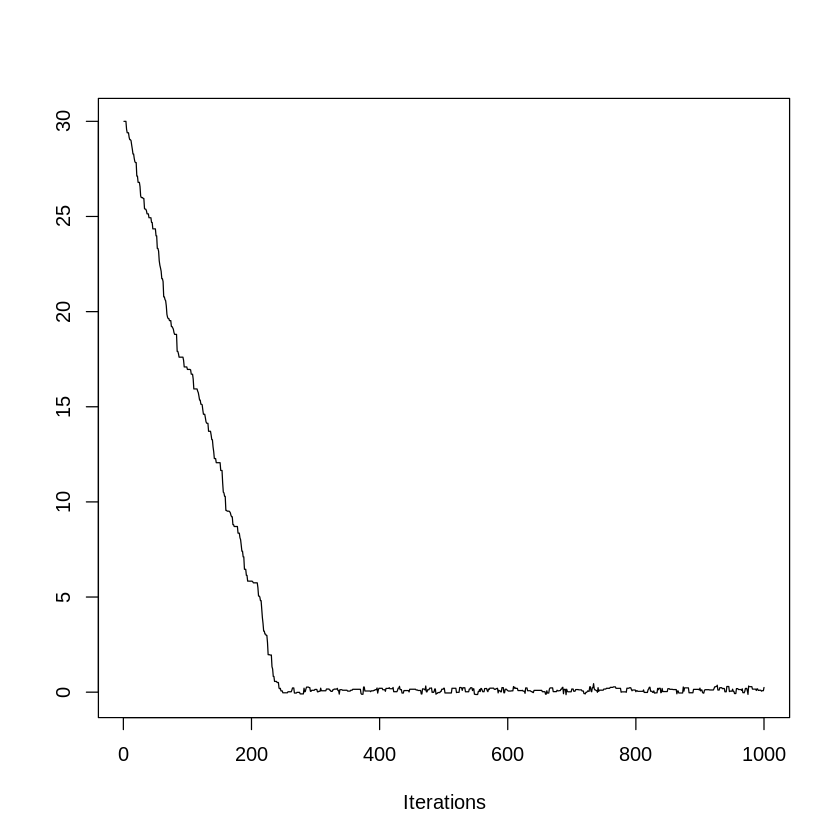

In [64]:
traceplot(as.mcmc(posterior_distrib$mu))

This is what we wanted, the Chain, after $\approx 230$ iterations stabilises around the stationary distribution.

**Thus if we discard the first $\approx 230$ timesteps, we get the stationary distribtion, which is, the posterior distrbution we wanted!**

### Now, let's plot posterior density against the prior to see how the data changed our belief for $\mu$

Removing first 250 timesteps

In [70]:
posterior_distrib$mu_keep = posterior_distrib$mu[-c(1:250)]

In [71]:
str(posterior_distrib)

List of 3
 $ mu            : num [1:1000] 30 30 30 30 29.6 ...
 $ n_accepts_rate: num 0.405
 $ mu_keep       : num [1:750] -0.0332 -0.0332 -0.0332 -0.0332 -0.0332 ...


Density Estimates

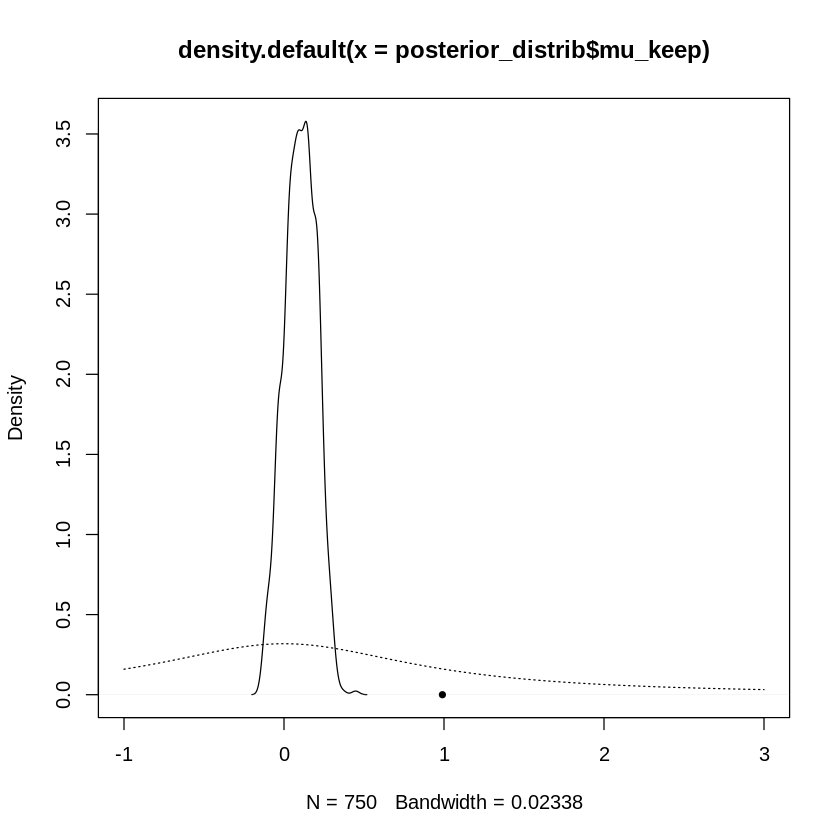

In [75]:
#Posterior Distribution
plot(density(posterior_distrib$mu_keep), xlim = c(-1,3))

#Prior Distribution
curve(dt(x = x,df = 1), lty = 3, add =TRUE)

#Sample Mean
points(ybar, 0, pch = 20)

The posterior distribution does look like a bit of trade-off between the sample mean and prior.

As we saw in the above example, MCMC can be a bit time consuming and requires fine tuning, we will automate this through JAGS.